<a href="https://colab.research.google.com/github/Gautam-Jaiswal/Stock-Project/blob/main/SP_Final_Multi_Layer_Stacked_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References :- 'https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/'

https://www.sciencedirect.com/science/article/pii/S2666827022000378


In [ ]:
pip install yfinance

In [2]:
stock_name = 'AAPL'

#GETTING AND CLEANSING OF DATA

In [173]:
import pandas as pd
import numpy as np
from numpy import array
import yfinance as yf

from datetime import datetime

import plotly.graph_objects as go
import plotly.express as px

import urllib.request
from PIL import Image

from skimage import io

import matplotlib.pyplot as plt

In [174]:
#1y,2y,5y,10y
df = yf.download(tickers=stock_name, period='5y' , interval='1d')

[*********************100%***********************]  1 of 1 completed


#DATA PREPARATION FOR MODEL BUILDING

In [175]:
from sklearn.preprocessing import MinMaxScaler

In [176]:
df_close_values = df.reset_index()['Close'][:-20]

In [177]:
# Scale each data into Range(0,1)

scaler = MinMaxScaler(feature_range=(0,1))
df_close_values = scaler.fit_transform(np.array(df_close_values).reshape(-1,1))

In [178]:
# Split Dataset into Training(80%) and Test data(20%)

training_size = int(len(df_close_values)*0.8)
train_data = df_close_values[0:training_size,:]
test_data = df_close_values[training_size:len(df_close_values),:1]

In [179]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [180]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [181]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# LSTM MODEL BUILDING

In [182]:
### Create the Stacked LSTM model
import math
from sklearn.metrics import mean_squared_error

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input

ts = 100 ✅

dense layer 1 :- 16, 8 , acc% = 75.3

dense layer 2 :- 12, 8 , acc% = 73

In [183]:
# BASIC SINGLE LAYER MODEL
'''model = keras.Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, validation_data=(X_train, y_train), verbose=1)'''

"model = keras.Sequential()\nmodel.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))\nmodel.add(Dense(1))\n\nmodel.compile(loss='mean_squared_error', optimizer='adam')\nmodel.fit(X_train, y_train, epochs=200, validation_data=(X_train, y_train), verbose=1)"

In [ ]:
# MULTI LAYER MODEL (STACKED MODEL)
# change df = 5yrs, ts= 100
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, validation_data=(X_train, y_train), verbose=1)

In [204]:
# DENSE LAYERS MODEL
# change df = 2yrs, ts= 30
'''model = Sequential()
model.add(Dense(16, input_shape=(time_step,), activation='relu', use_bias=False))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=400)'''

"model = Sequential()\nmodel.add(Dense(16, input_shape=(time_step,), activation='relu', use_bias=False))\nmodel.add(Dense(8, activation='relu'))\nmodel.add(Dense(1))\n\nmodel.compile(loss='mean_squared_error', optimizer='adam')\nmodel.fit(X_train, y_train, epochs=400)"

In [205]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [206]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [207]:
print(f'RMSE measure for Training Data : {round(math.sqrt(mean_squared_error(y_train,train_predict)), 2)}')
print(f'RMSE measure for Test Data : {round(math.sqrt(mean_squared_error(y_test,test_predict)), 2)}')

RMSE measure for Training Data : 90.56
RMSE measure for Test Data : 153.46


In [208]:
### Plotting 
look_back=time_step

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_close_values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close_values)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close_values)-1, :] = test_predict

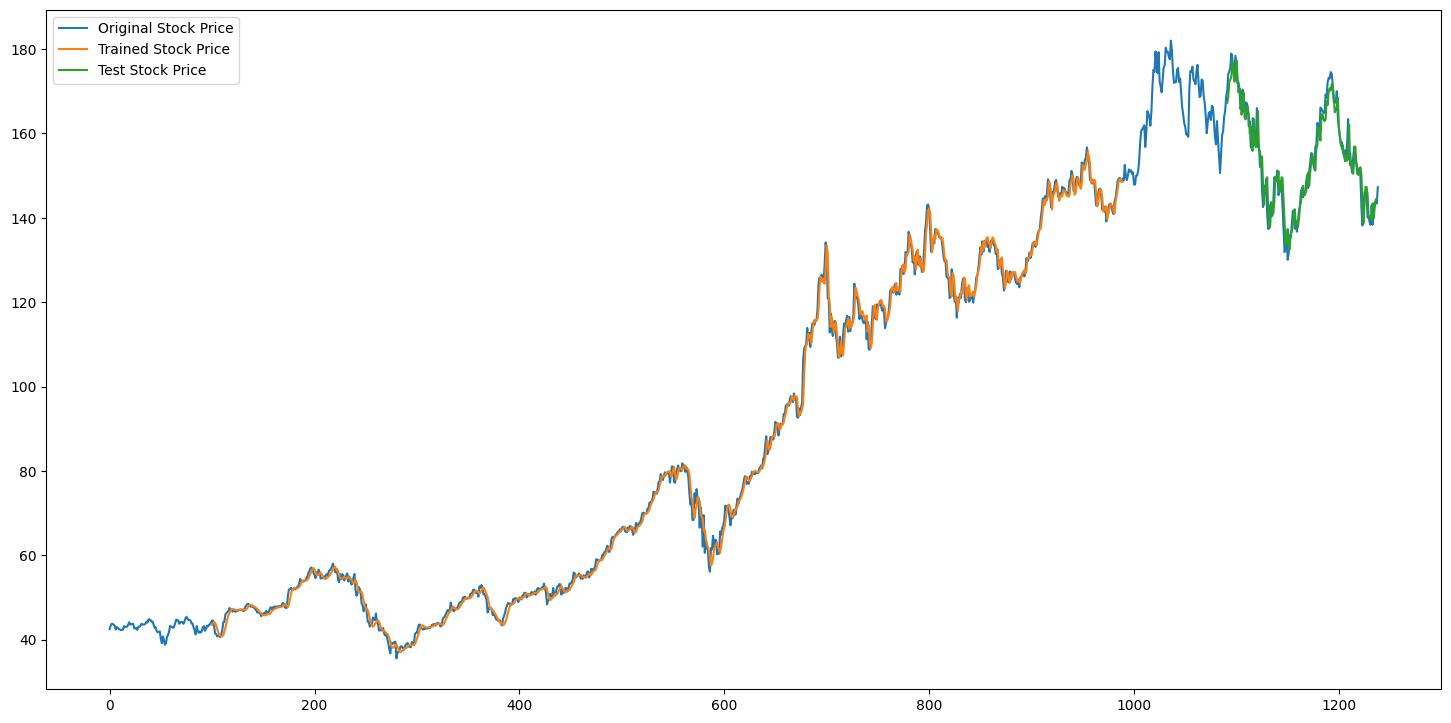

In [209]:
# plot baseline and predictions
plt.figure(dpi=100, figsize=(18, 9))
plt.plot(scaler.inverse_transform(df_close_values), label='Original Stock Price')
plt.plot(trainPredictPlot, label='Trained Stock Price')
plt.plot(testPredictPlot,  label='Test Stock Price')
plt.legend()
plt.show()

# Future Prediction

In [210]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)

In [211]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [212]:
# demonstrate prediction for next 20 days
lst_output=[]
n_steps=time_step
i=0
while(i<20):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

[0.7631851]


In [213]:
day_new=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+21)

# Graphical Output

In [214]:
df4 = df.reset_index()['Close'].tolist()

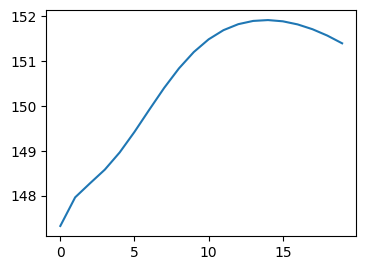

In [215]:
plt.figure(dpi=100, figsize=(4,3))
plt.plot(scaler.inverse_transform(lst_output))

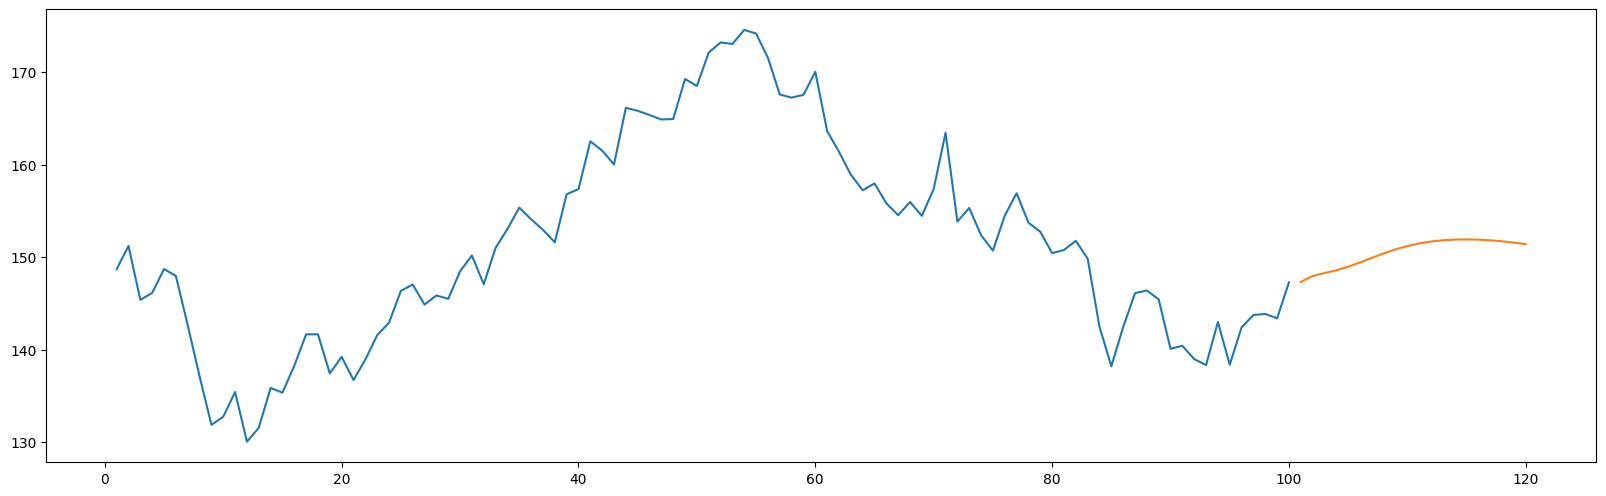

In [216]:
plt.figure(dpi=100, figsize=(20,6))

plt.plot(day_new,scaler.inverse_transform(df_close_values[len(df_close_values)-time_step:]) , label='STOCK PRICE')
plt.plot(day_pred,scaler.inverse_transform(lst_output) , label='FUTURE PREDICTED STOCK PRICE')

## GRAPHICAL COMPARSION WITH ORIGINAL VALUE

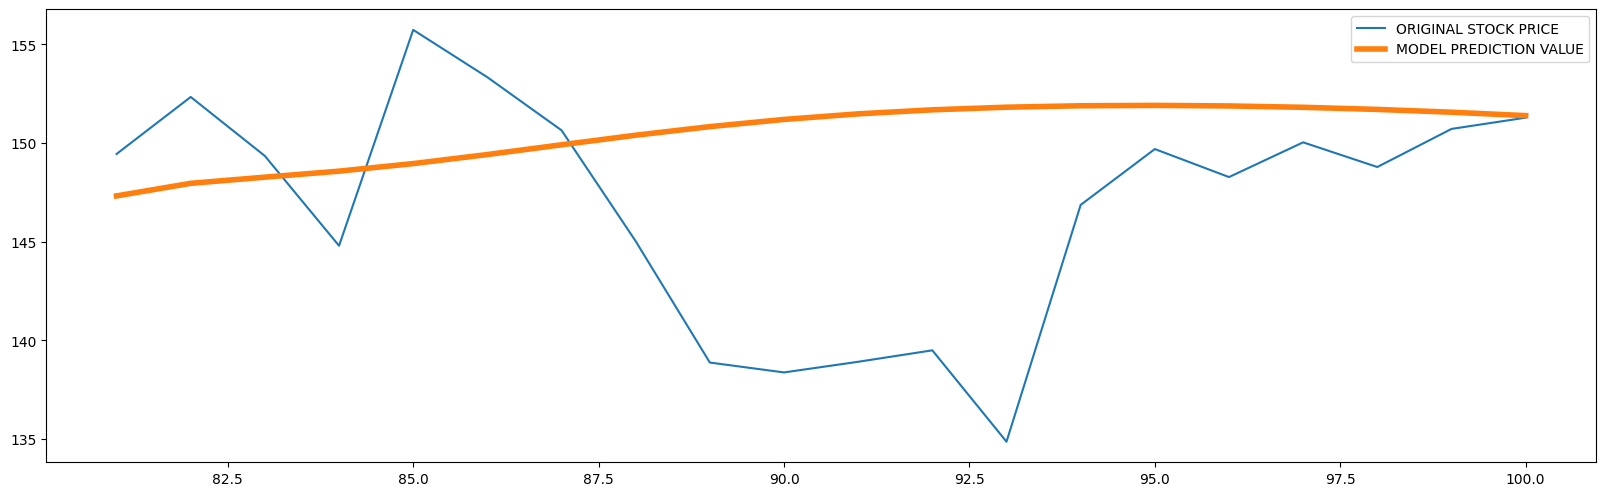

In [217]:
day_prediction = np.arange(time_step-19,time_step+1)

plt.figure(dpi=100, figsize=(20,6))

plt.plot(day_prediction,df4[len(df4)-20:], label='ORIGINAL STOCK PRICE')
plt.plot(day_prediction ,scaler.inverse_transform(lst_output) , label='MODEL PREDICTION VALUE', linewidth=4)
plt.legend()
plt.show()